In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy.random as rd
import time
import pandas as pd

In [7]:
def to_matrice(dataset):
    # marche pour un dataset avec notes entre 0 et note max
    # à adapter sinon
    
    user = dataset.iloc[:, 0]
    item = dataset.iloc[:, 1]

    utile = dataset.iloc[:, 0:3]
    data_array = utile.to_numpy()  # to_numpy devient get_values sur python 3

    user_dict = {}
    for k in range(data_array.shape[0]):
        user_dict[data_array[k][0]] = data_array[k][1]
    nb_user = len(user_dict)

    item_dict = {}
    for k in range(data_array.shape[0]):
        item_dict[data_array[k][1]] = data_array[k][0]
    nb_item = len(item_dict)

    nb_ratings = data_array.shape[0]
    pourc = round(100 * nb_ratings / (nb_user * nb_item), 2)

    print("Il y a ", nb_user, " utilisateurs et ", nb_item, "plats et ", nb_ratings, "notes, soit une matrice ", pourc,
          "% pleine.")

    # Matrice note

    # on commence par remplir une matrice avec que des zeros ou des -1, à voir
    M = np.zeros((nb_user, nb_ratings))

    # Il faut maintenant réindexer
    # Stratégie :

    index = 0
    for cle in user_dict.keys():
        user_dict[cle] = index
        index += 1

    index = 0
    for cle in item_dict.keys():
        item_dict[cle] = index
        index += 1

    for x in data_array:
        user = user_dict.get(x[0])
        item = item_dict.get(x[1])
        rating = x[2]
        M[user][item] = rating + 1  # je fais donc des notes de 1 à 3 et on laisse 0 pour les non notés

    return M

In [116]:
def S(y,x, a):
    return float((y-a.dot(x.T))**2)

def gradS(y,x, a):
    S = []
    for p in range(a.size):
        aux = 0
        aux -= float(x[0][p]) * (y - float(a.dot(x.T)))
        S.append(aux)
    return S

def gradS_reg(y,x, a,lamb):
    S = []
    for p in range(a.size):
        aux = 0
        aux -= float(x[0][p]) * (y - float(a.dot(x.T)))
        S.append(aux)
    return S+list(lamb*2*a*np.linalg.norm(x))

def perte_quadr(M,U,V):
    MM=U.dot(V.T)
    p = 0
    n, m = M.shape
    non_nul=n*m
    for i in range(n):
        for j in range(m):
            if M[i][j]==0:
                non_nul-=1
                continue    # on ne considère que la perte sur le train , c'est à dire sur les facteurs deja rempli
            p += (M[i][j] - MM[i][j]) ** 2
    return p/non_nul

def perte_quadr_reg(M,U,V,lamb):
    MM=U.dot(V.T)
    p = 0
    n, m = M.shape
    for i in range(n):
        for j in range(m):
            if M[i][j]==0:
                continue    # on ne considère que la perte sur le train , c'est à dire sur les facteurs deja rempli
            p += (M[i][j] - MM[i][j]) ** 2
    return p + lamb*(np.linalg.norm(U)+np.linalg.norm(V))


def perte_rapide(M,U,V,i,j):
    MM=U.dot(V.T)
    p = 0
    n, m = M.shape
    for ligne in range(n):
        if M[ligne][j]==0:   #de meme
            continue
        p+=(M[ligne][j] - MM[ligne][j]) ** 2
    for colonne in range(m):
        if M[i][colonne]==0:   #de meme
            continue
        p+=(M[i][colonne] - MM[i][colonne]) ** 2
    return p


def perte_rapide_reg(M,U,V,i,j,lamb):
    MM=U.dot(V.T)
    p = 0
    n, m = M.shape
    for ligne in range(n):
        if M[ligne][j]==0:   #de meme
            continue
        p+=(M[ligne][j] - MM[ligne][j]) ** 2
    for colonne in range(m):
        if M[i][colonne]==0:   #de meme
            continue
        p+=(M[i][colonne] - MM[i][colonne]) ** 2
    return p+ lamb*np.linalg.norm(U)+lamb*np.linalg.norm(V)

In [41]:
def train_and_test(M,x):
    train=np.zeros(M.shape)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            r = rd.random()
            if r >= x:
                train[i][j]=M[i][j]
    test=M-train
    return train, test

In [50]:
def mon_idee_creuse_tres_rapide(M, l, iter, pas, eps, courbes_seulement,lamb):
    # le paramètre courbe_seulement c'est si on veut afficher toutes les étapes ou juste les courbes pour comparer les résultats
    etape, perte_etape, temps, perte_temps = [], [], [], []

    MAT_U = np.array([[.1 for k in range(l)] for k in range(M.shape[0])])
    MAT_V = np.array([[.1 for k in range(l)] for k in range(M.shape[1])])
    L1 = [k for k in range(M.shape[0])]
    L2 = [k for k in range(M.shape[1])]
    rd.shuffle(L1)
    rd.shuffle(L2)

    #enlever les zeros
    paires=[]
    for i in L1:
        for j in L2:
            if M[i][j]!=0:
                paires.append((i,j))

    #if (courbes_seulement == False):
      #  print("Matrice à factoriser :")
      #  print(M)

    debut = time.time()

    for ww in range(iter):
        pas /= 1.1

        for paire in paires:
            n,m = paire
            a = float(M[n][m])
            U = MAT_U[n:n + 1]
            V = MAT_V[m:m + 1]
            e, ee = 0, 0

            # On minismise sur V à U constant
            while e<3:
                gradient = gradS_reg(a, U, V,lamb)
                #if (max(gradient) < eps) and (min(gradient) > -eps):
                    #break
                e += 1
                for i in range(l):
                    p1 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    V[0][i] -= pas * grad
                    p2 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        V[0][i] += pas * grad


            MAT_V[m] = V
                # On minimise sur U à V constant
            while ee<3:
                gradient = gradS_reg(a, U, V,lamb)
                #if (max(gradient) < eps) and (min(gradient) > -eps):
                    #break
                ee += 1
                for i in range(l):
                    p1 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    U[0][i] -= pas * grad
                    p2 = perte_rapide_reg(M,MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        U[0][i] += pas * grad

            MAT_U[n] = U

        if (courbes_seulement == False):
            print("etape", ww + 1, "sur", iter)
        etape.append(ww)
        perte=perte_quadr(M,MAT_U,MAT_V)
        perte_etape.append(perte)
        temps.append(time.time() - debut)
        perte_temps.append(perte)

    fin = time.time()
    #if (courbes_seulement == False):
       # print(MAT_U.dot(MAT_V.T))
        #print(M)

    print("perte = ", perte_quadr(M, MAT_U,MAT_V))
    print("temps d'execution : ", fin - debut, "secondes.")
    plt.plot(etape, perte_etape)
    plt.title("erreur par étape")
    plt.xlabel("étapes")
    plt.ylabel("erreur quadratique totale")
    plt.show()

    plt.plot(temps, perte_temps)
    plt.title("erreur en fonction du temps")
    plt.xlabel("temps en secondes")
    plt.ylabel("erreur quadratique totale")
    plt.show()


etape 1 sur 5
etape 2 sur 5
etape 3 sur 5
etape 4 sur 5
etape 5 sur 5
perte =  0.23088966622595805
temps d'execution :  10.889812707901001 secondes.


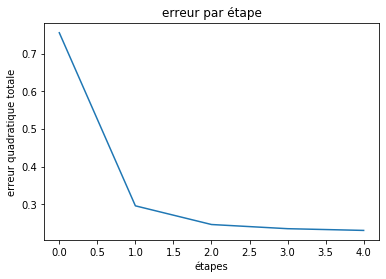

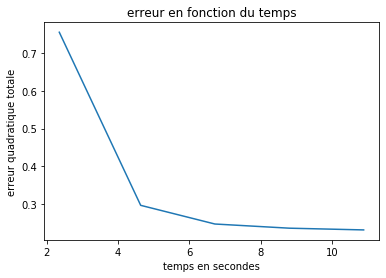

In [56]:
mon_idee_creuse_tres_rapide(M,l,iter,pas,eps,False,20)

In [62]:
def mon_idee_creuse_tres_rapide_test(M, l, iter, pas, eps, courbes_seulement,lamb,taille_test):
    # le paramètre courbe_seulement c'est si on veut afficher toutes les étapes ou juste les courbes pour comparer les résultats
    etape, perte_etape, temps, perte_temps = [], [], [], []
    perte_test_etape, perte_test_temps = [], []
    
    train, test = train_and_test(M,taille_test)
    
    M_old=M
    M=train
    
    MAT_U = np.array([[.1 for k in range(l)] for k in range(M.shape[0])])
    MAT_V = np.array([[.1 for k in range(l)] for k in range(M.shape[1])])
    L1 = [k for k in range(M.shape[0])]
    L2 = [k for k in range(M.shape[1])]
    rd.shuffle(L1)
    rd.shuffle(L2)

    #enlever les zeros
    paires=[]
    for i in L1:
        for j in L2:
            if M[i][j]!=0:
                paires.append((i,j))

    #if (courbes_seulement == False):
      #  print("Matrice à factoriser :")
      #  print(M)

    debut = time.time()

    for ww in range(iter):
        pas /= 1.1

        for paire in paires:
            n,m = paire
            a = float(M[n][m])
            U = MAT_U[n:n + 1]
            V = MAT_V[m:m + 1]
            e, ee = 0, 0

            # On minismise sur V à U constant
            while e<3:
                gradient = gradS_reg(a, U, V,lamb)
                #if (max(gradient) < eps) and (min(gradient) > -eps):
                    #break
                e += 1
                for i in range(l):
                    p1 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    V[0][i] -= pas * grad
                    p2 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        V[0][i] += pas * grad


            MAT_V[m] = V
                # On minimise sur U à V constant
            while ee<3:
                gradient = gradS_reg(a, U, V,lamb)
                #if (max(gradient) < eps) and (min(gradient) > -eps):
                    #break
                ee += 1
                for i in range(l):
                    p1 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    U[0][i] -= pas * grad
                    p2 = perte_rapide_reg(M,MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        U[0][i] += pas * grad

            MAT_U[n] = U

        #if (courbes_seulement == False):
           # print("etape", ww + 1, "sur", iter)
        etape.append(ww)
        perte=perte_quadr(M,MAT_U,MAT_V)
        perte_etape.append(perte)
        temps.append(time.time() - debut)
        perte_temps.append(perte)
        
        perte_t=perte_quadr(test,MAT_U,MAT_V)
        perte_test_etape.append(perte_t)
        perte_test_temps.append(perte_t)

    fin = time.time()
    #if (courbes_seulement == False):
       # print(MAT_U.dot(MAT_V.T))
        #print(M)

    print("perte = ", perte_quadr(M, MAT_U,MAT_V))
    print("temps d'execution : ", fin - debut, "secondes.")
    plt.plot(etape, perte_etape)
    plt.title("erreur par étape")
    plt.xlabel("étapes")
    plt.ylabel("erreur quadratique totale")
    plt.show()

    plt.plot(temps, perte_temps)
    plt.title("erreur en fonction du temps")
    plt.xlabel("temps en secondes")
    plt.ylabel("erreur quadratique totale")
    plt.show()
    
    plt.plot(etape, perte_test_etape)
    plt.title("test")
    plt.show()


lambda =  0
perte =  4.5479452054794525
temps d'execution :  0.041815757751464844 secondes.


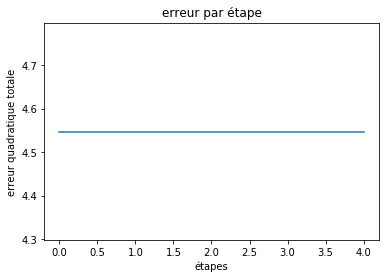

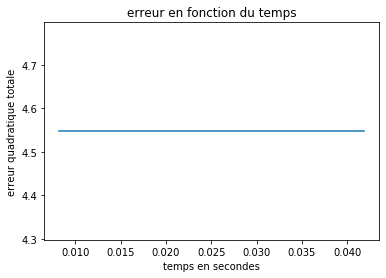

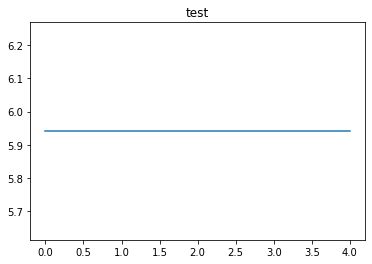

lambda =  3
perte =  0.14642042853511308
temps d'execution :  1.5823428630828857 secondes.


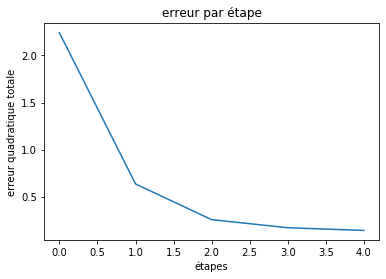

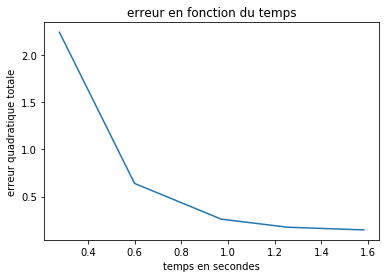

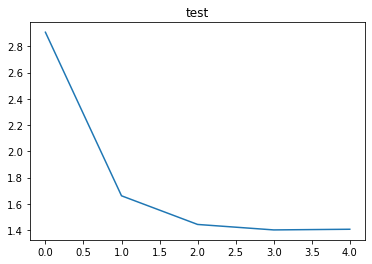

lambda =  6
perte =  0.12794555796743998
temps d'execution :  3.753857374191284 secondes.


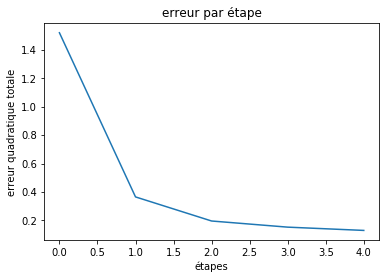

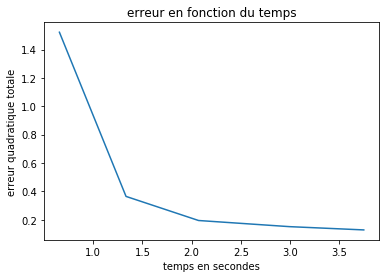

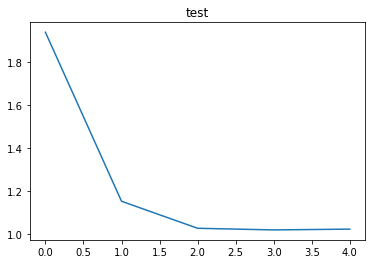

lambda =  9
perte =  0.14246641560247955
temps d'execution :  4.709754943847656 secondes.


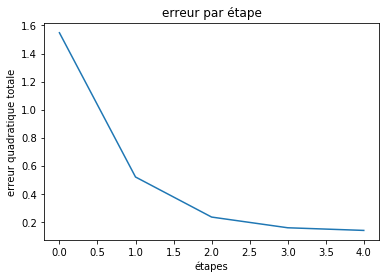

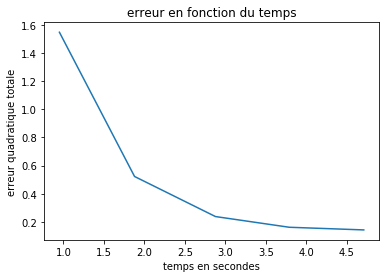

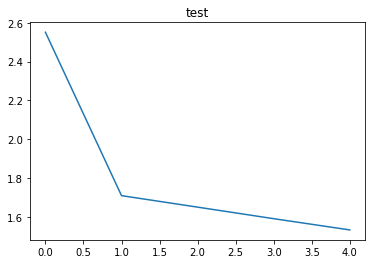

lambda =  12
perte =  0.15821547134386174
temps d'execution :  6.3749542236328125 secondes.


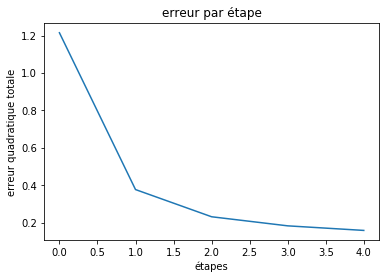

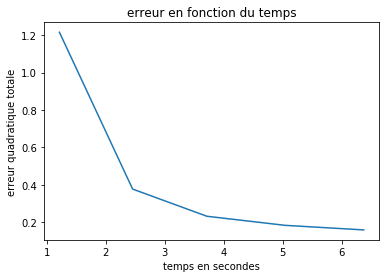

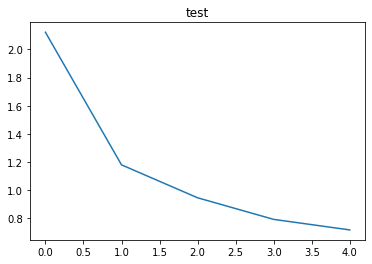

lambda =  15
perte =  0.16988188264936288
temps d'execution :  8.2414231300354 secondes.


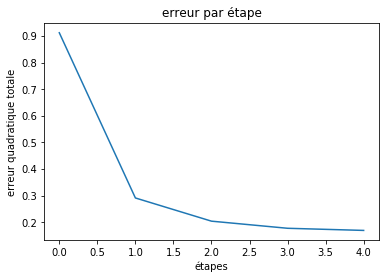

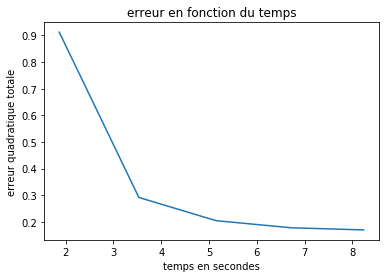

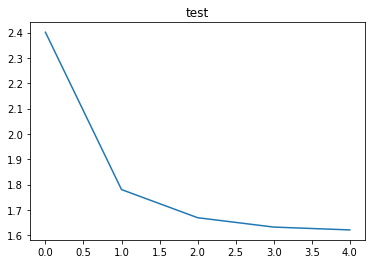

lambda =  18
perte =  0.21008135752402077
temps d'execution :  10.575095891952515 secondes.


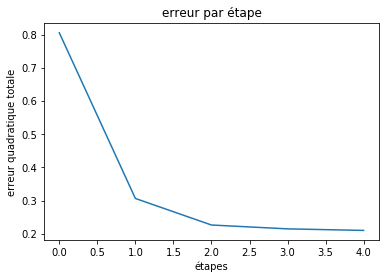

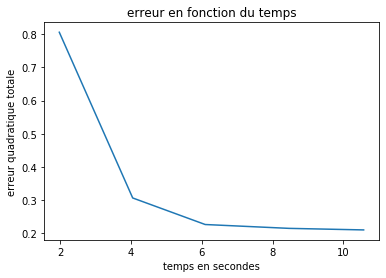

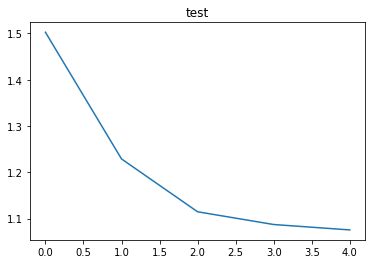

lambda =  21
perte =  0.2421952016101418
temps d'execution :  11.622071504592896 secondes.


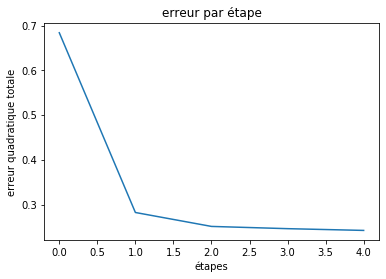

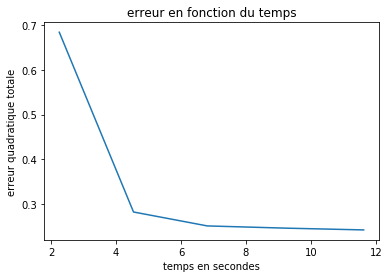

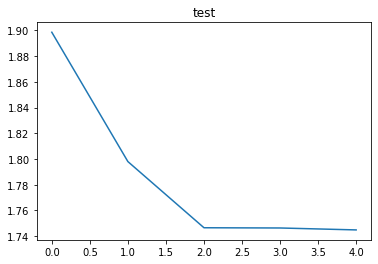

lambda =  24
perte =  0.3025978997750227
temps d'execution :  12.820862531661987 secondes.


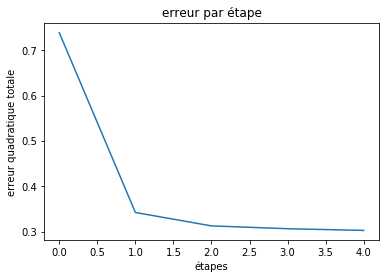

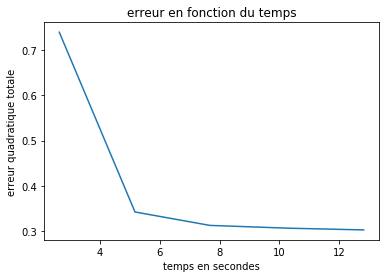

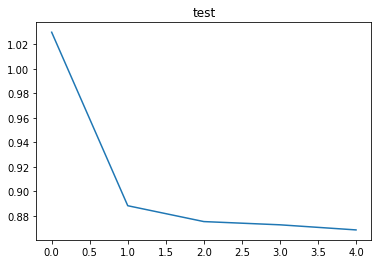

lambda =  27
perte =  0.37276783894412313
temps d'execution :  16.201153993606567 secondes.


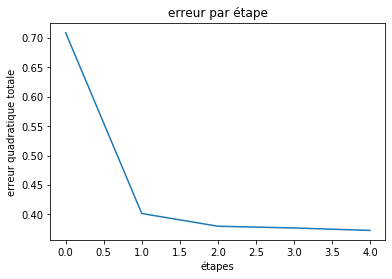

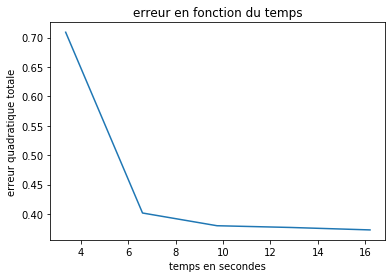

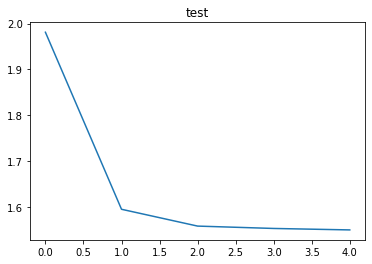

lambda =  30
perte =  0.40679464796849135
temps d'execution :  18.821340799331665 secondes.


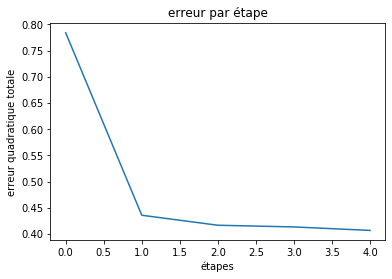

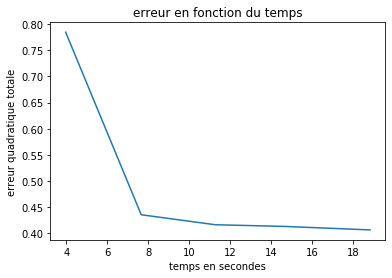

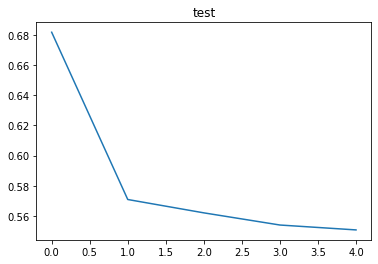

lambda =  33
perte =  0.5177433113376689
temps d'execution :  18.78816246986389 secondes.


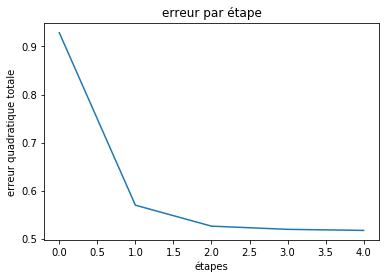

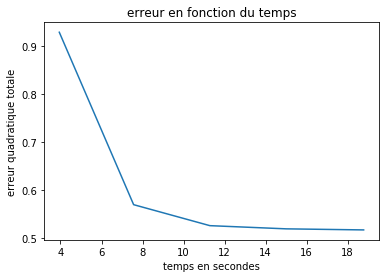

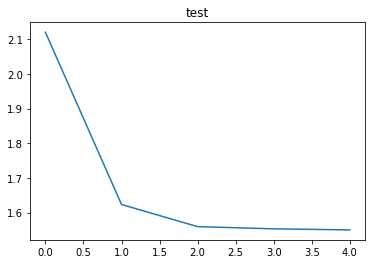

lambda =  36
perte =  0.5516219648719088
temps d'execution :  19.941107511520386 secondes.


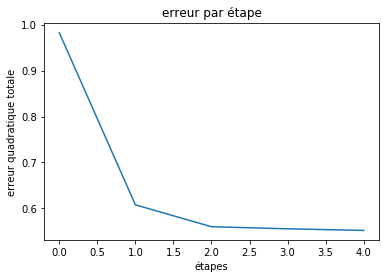

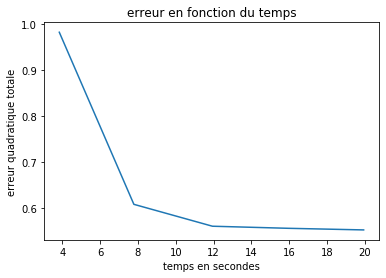

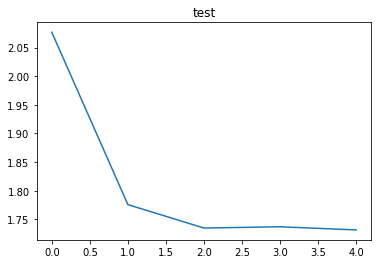

lambda =  39
perte =  0.6666674516684163
temps d'execution :  20.596501111984253 secondes.


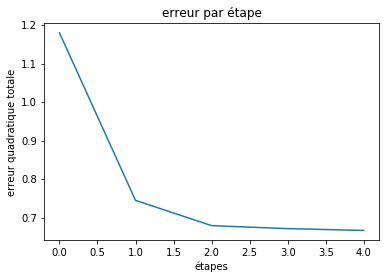

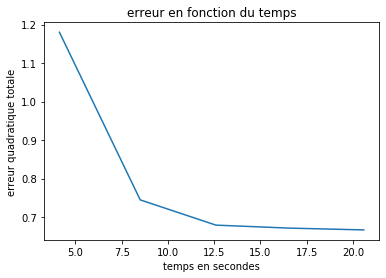

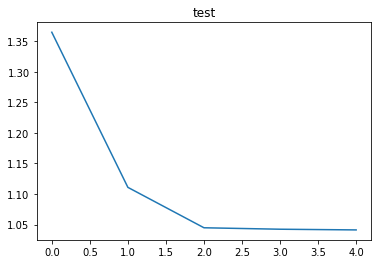

lambda =  42
perte =  0.8113369214851407
temps d'execution :  22.222026348114014 secondes.


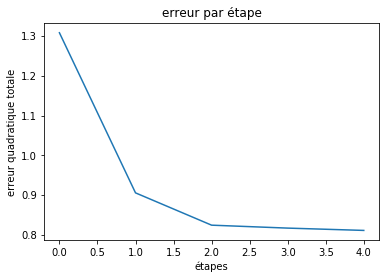

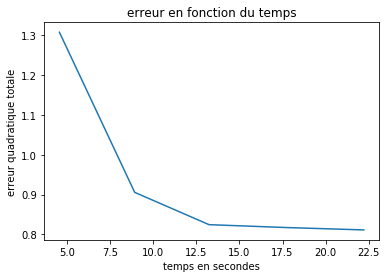

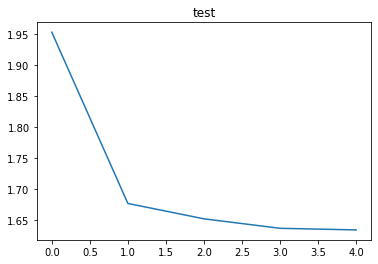

lambda =  45
perte =  0.8762488946181397
temps d'execution :  25.617883443832397 secondes.


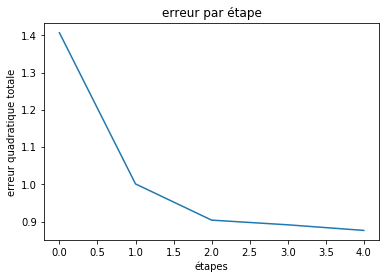

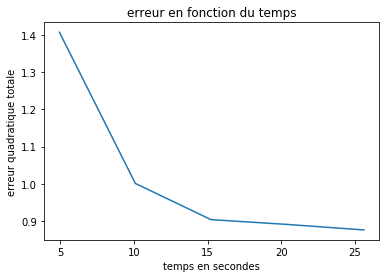

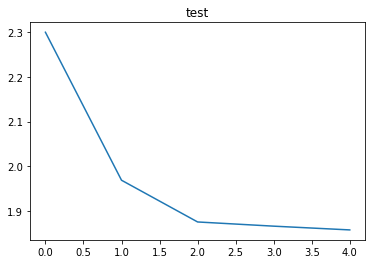

lambda =  48
perte =  0.9865574232482409
temps d'execution :  28.0891170501709 secondes.


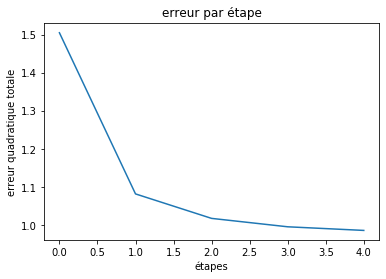

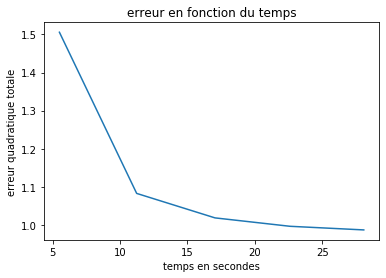

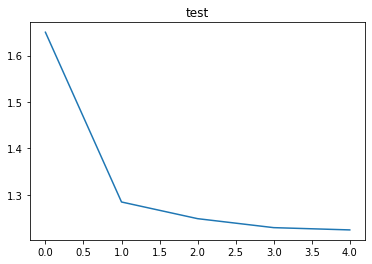

lambda =  51
perte =  1.2232243256119923
temps d'execution :  30.897075414657593 secondes.


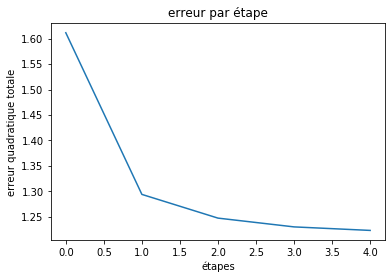

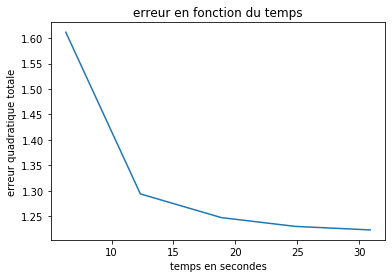

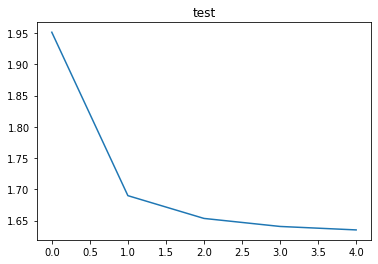

lambda =  54
perte =  1.4528553546267733
temps d'execution :  36.10790467262268 secondes.


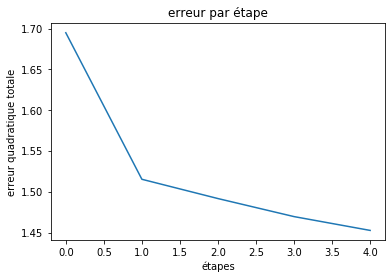

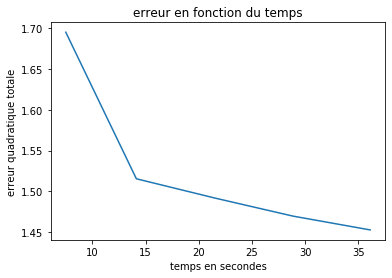

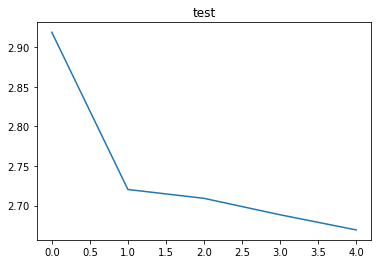

lambda =  57
perte =  1.6510320625855657
temps d'execution :  35.90370726585388 secondes.


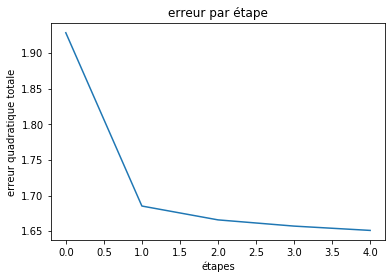

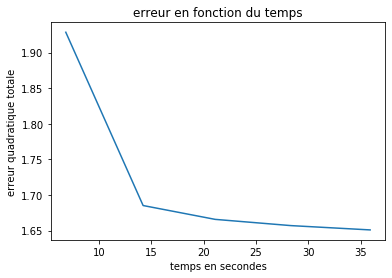

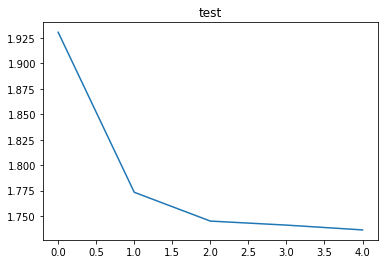

lambda =  60
perte =  1.630925869908075
temps d'execution :  40.908182859420776 secondes.


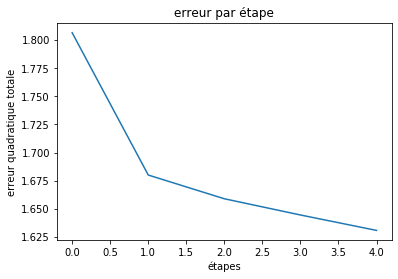

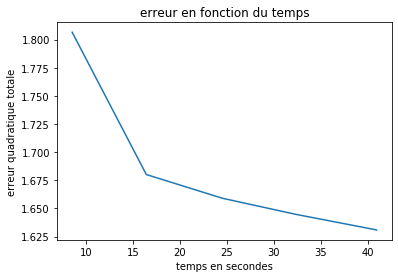

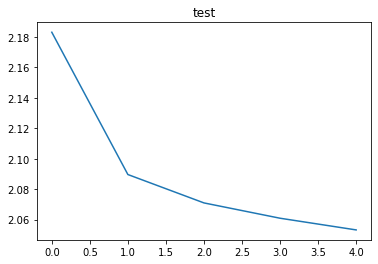

lambda =  63
perte =  1.7541274398945232
temps d'execution :  39.75001335144043 secondes.


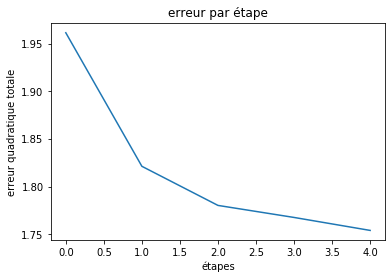

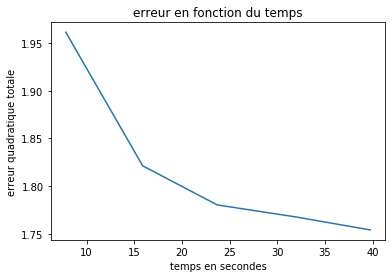

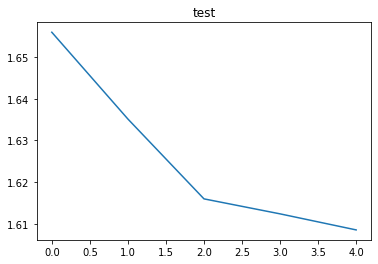

lambda =  66
perte =  1.7663530943382117
temps d'execution :  46.34410762786865 secondes.


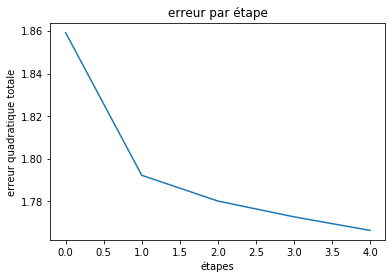

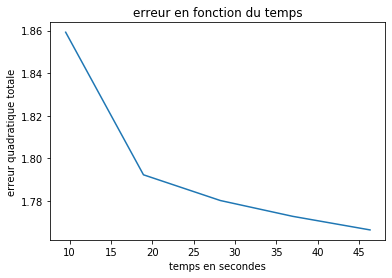

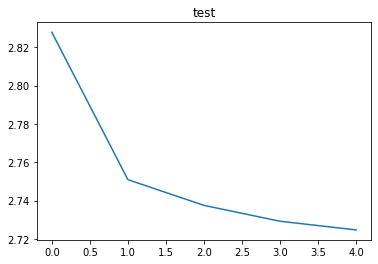

lambda =  69
perte =  1.869763989306214
temps d'execution :  42.60829043388367 secondes.


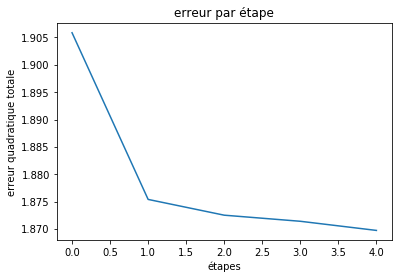

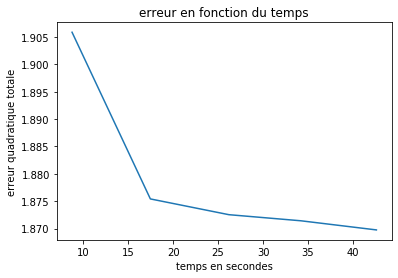

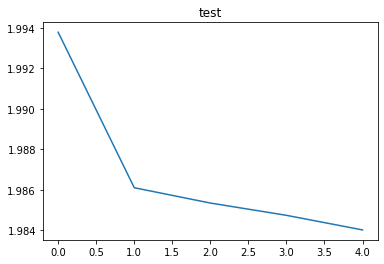

lambda =  72
perte =  1.8202896599736738
temps d'execution :  53.73309302330017 secondes.


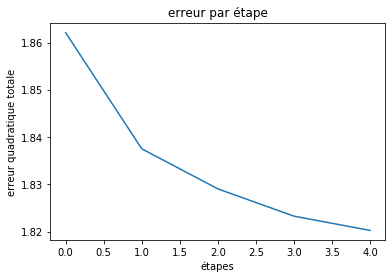

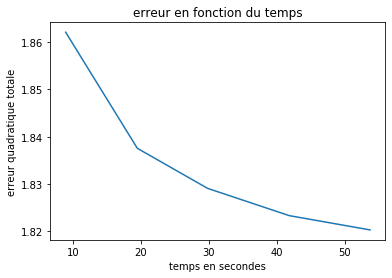

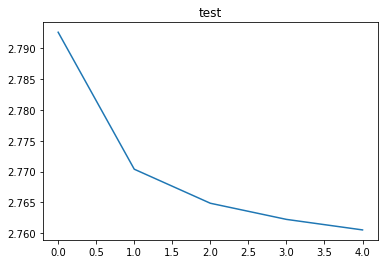

lambda =  75
perte =  2.0111055481854083
temps d'execution :  47.489160776138306 secondes.


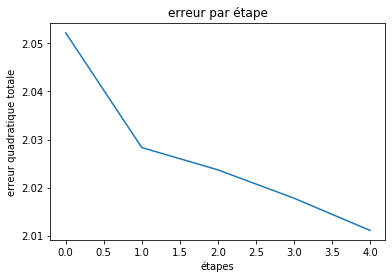

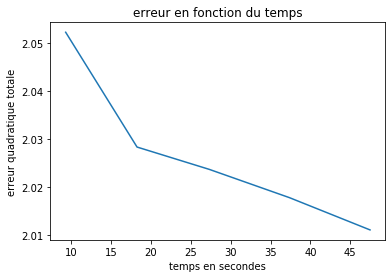

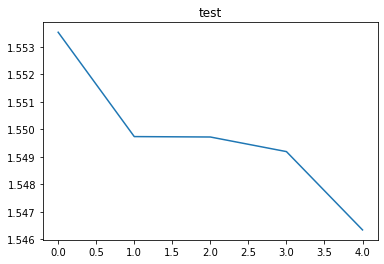

lambda =  78
perte =  1.7699486561975386
temps d'execution :  59.80192708969116 secondes.


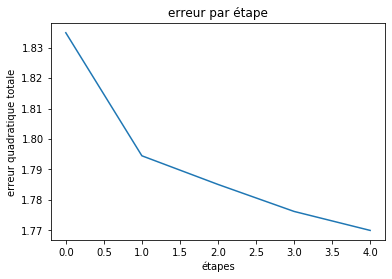

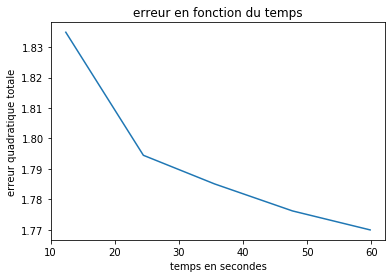

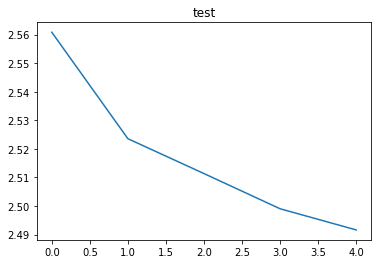

lambda =  81
perte =  1.827991292088221
temps d'execution :  48.124804973602295 secondes.


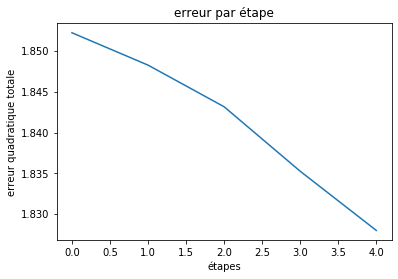

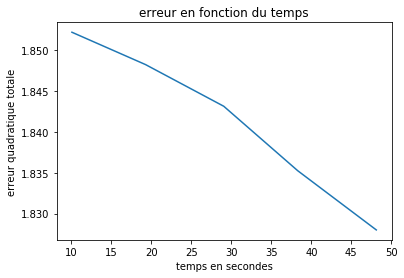

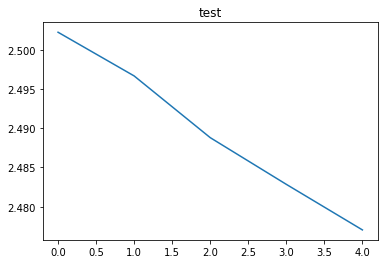

lambda =  84
perte =  2.0627017811966692
temps d'execution :  50.005730867385864 secondes.


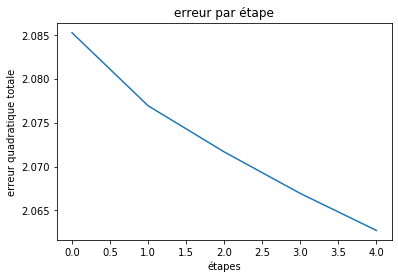

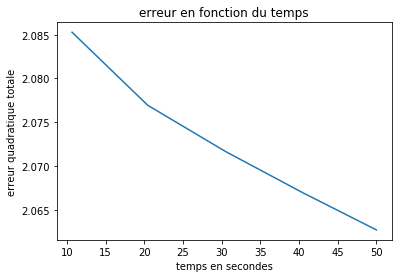

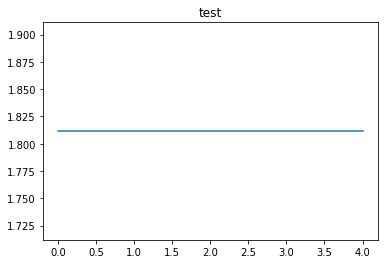

lambda =  87
perte =  1.8259433767549054
temps d'execution :  58.22735285758972 secondes.


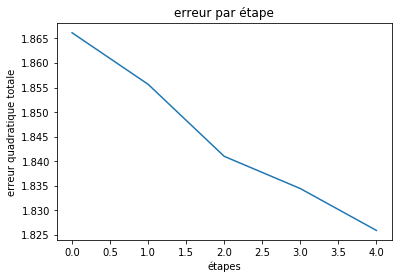

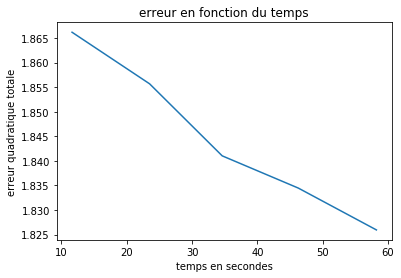

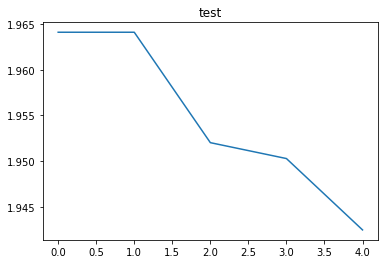

lambda =  90
perte =  1.950429857776857
temps d'execution :  49.67338228225708 secondes.


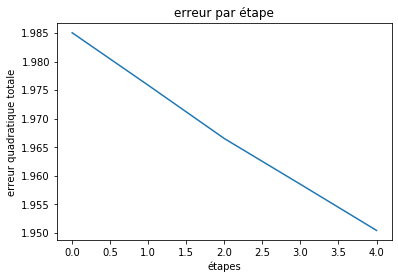

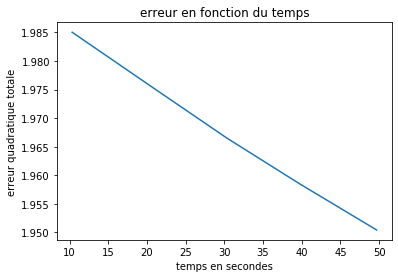

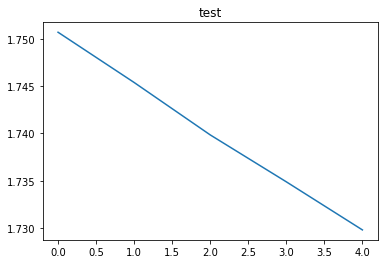

lambda =  93
perte =  1.893252996235973
temps d'execution :  59.995789766311646 secondes.


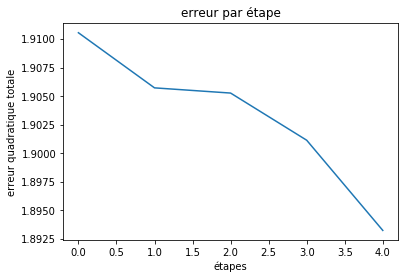

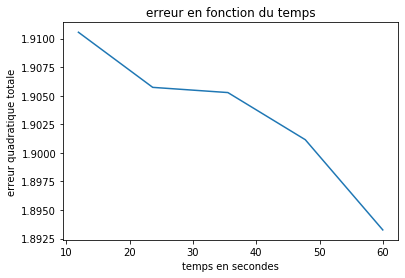

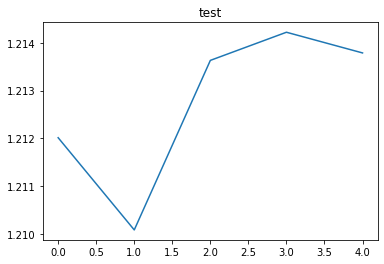

lambda =  96
perte =  1.7093188231012164
temps d'execution :  68.22122859954834 secondes.


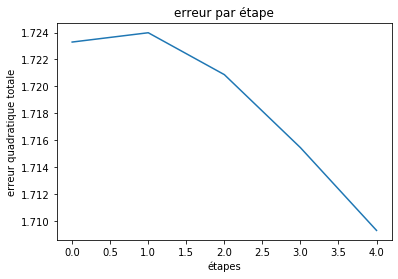

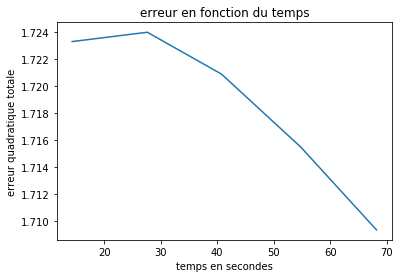

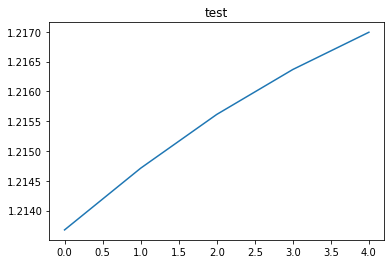

lambda =  99
perte =  1.6988585141594355
temps d'execution :  62.83887696266174 secondes.


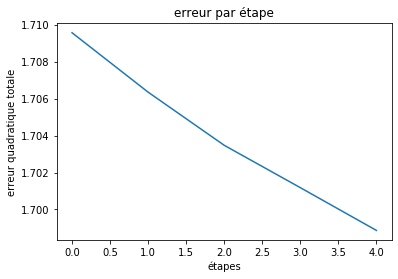

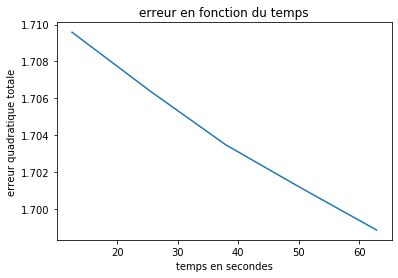

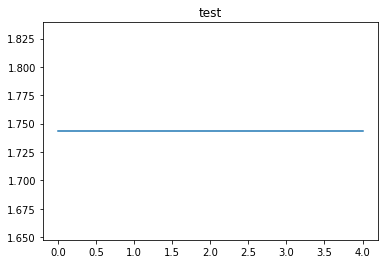

In [63]:
for l in range(0,100,3):
    print ("lambda = ", l)
    mon_idee_creuse_tres_rapide_test(M,latent,iter,pas,eps,False,l,.2)


In [67]:
def test_lambda(M, l, iter, pas, eps,lamb,taille_test):
    # le paramètre courbe_seulement c'est si on veut afficher toutes les étapes ou juste les courbes pour comparer les résultats
    etape, perte_etape, temps, perte_temps = [], [], [], []
    perte_test_etape, perte_test_temps = [], []
    
    train, test = train_and_test(M,taille_test)
    
    M_old=M
    M=train
    
    MAT_U = np.array([[.1 for k in range(l)] for k in range(M.shape[0])])
    MAT_V = np.array([[.1 for k in range(l)] for k in range(M.shape[1])])
    L1 = [k for k in range(M.shape[0])]
    L2 = [k for k in range(M.shape[1])]
    rd.shuffle(L1)
    rd.shuffle(L2)

    #enlever les zeros
    paires=[]
    for i in L1:
        for j in L2:
            if M[i][j]!=0:
                paires.append((i,j))

    debut = time.time()

    for ww in range(iter):
        pas /= 1.1

        for paire in paires:
            n,m = paire
            a = float(M[n][m])
            U = MAT_U[n:n + 1]
            V = MAT_V[m:m + 1]
            e, ee = 0, 0

            # On minismise sur V à U constant
            while e<3:
                gradient = gradS_reg(a, U, V,lamb)
                e += 1
                for i in range(l):
                    p1 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    V[0][i] -= pas * grad
                    p2 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        V[0][i] += pas * grad


            MAT_V[m] = V
                # On minimise sur U à V constant
            while ee<3:
                gradient = gradS_reg(a, U, V,lamb)
                ee += 1
                for i in range(l):
                    p1 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    U[0][i] -= pas * grad
                    p2 = perte_rapide_reg(M,MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        U[0][i] += pas * grad

            MAT_U[n] = U

       
    perte=perte_quadr(M,MAT_U,MAT_V)
    perte_t=perte_quadr(test,MAT_U,MAT_V)
    return (perte, perte_t)



In [68]:
latent = 8
iter = 7
pas = .1
eps = 0.01

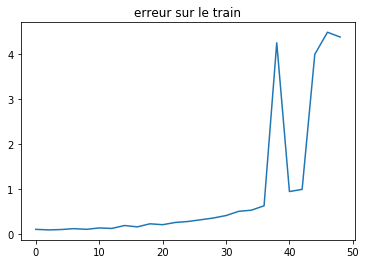

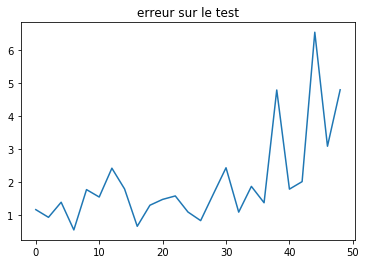

In [71]:
erreur_train, erreur_test, lamb = [],[], []

for l in range (0,50,2):
    lamb.append(l)
    e, ee = test_lambda(M,latent,iter,pas,eps,l,.2)
    erreur_train.append(e)
    erreur_test.append(ee)

plt.plot(lamb,erreur_train)
plt.title("erreur sur le train")
plt.show()

plt.plot(lamb,erreur_test)
plt.title("erreur sur le test")
plt.show()

## Donc on va choisir $\lambda=6$

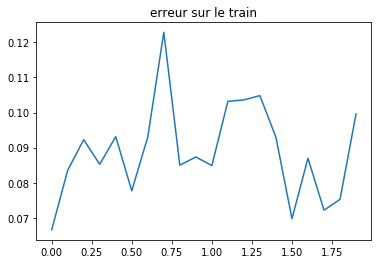

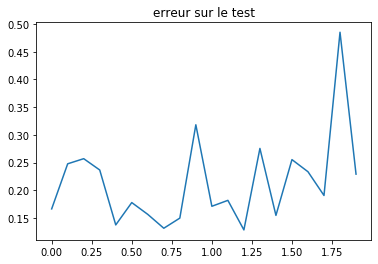

In [111]:
erreur_train, erreur_test, lamb = [],[], []
liste = [.1*k for k in range(20)]

for l in liste:
    lamb.append(l)
    e, ee = test_lambda(M,latent,iter,pas,eps,l,.2)
    erreur_train.append(e)
    erreur_test.append(ee)

plt.plot(lamb,erreur_train)
plt.title("erreur sur le train")
plt.show()

plt.plot(lamb,erreur_test)
plt.title("erreur sur le test")
plt.show()

## Comparaison prédiction régularisée ou non : 

In [128]:
def f(M, l, iter, pas, eps,lamb,taille_test):
    # le paramètre courbe_seulement c'est si on veut afficher toutes les étapes ou juste les courbes pour comparer les résultats
    etape, perte_etape, temps, perte_temps = [], [], [], []
    perte_test_etape, perte_test_temps = [], []
    
    train, test = train_and_test(M,taille_test)
    
    M_old=M
    M=train
    
    MAT_U = np.array([[.1 for k in range(l)] for k in range(M.shape[0])])
    MAT_V = np.array([[.1 for k in range(l)] for k in range(M.shape[1])])
    L1 = [k for k in range(M.shape[0])]
    L2 = [k for k in range(M.shape[1])]
    rd.shuffle(L1)
    rd.shuffle(L2)

    #enlever les zeros
    paires=[]
    for i in L1:
        for j in L2:
            if M[i][j]!=0:
                paires.append((i,j))

    debut = time.time()

    for ww in range(iter):
        pas /= 1.1

        for paire in paires:
            n,m = paire
            a = float(M[n][m])
            U = MAT_U[n:n + 1]
            V = MAT_V[m:m + 1]
            e, ee = 0, 0

            # On minismise sur V à U constant
            while e<3:
                gradient = gradS_reg(a, U, V,lamb)
                e += 1
                for i in range(l):
                    p1 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    V[0][i] -= pas * grad
                    p2 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        V[0][i] += pas * grad


            MAT_V[m] = V
                # On minimise sur U à V constant
            while ee<3:
                gradient = gradS_reg(a, U, V,lamb)
                ee += 1
                for i in range(l):
                    p1 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    U[0][i] -= pas * grad
                    p2 = perte_rapide_reg(M,MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        U[0][i] += pas * grad

            MAT_U[n] = U
        etape.append(ww)
        perte=perte_quadr(M,MAT_U,MAT_V)
        perte_etape.append(perte)
        temps.append(time.time() - debut)
        perte_temps.append(perte)
        
        perte_t=perte_quadr(test,MAT_U,MAT_V)
        perte_test_etape.append(perte_t)
        perte_test_temps.append(perte_t)

    
    
    p1=plt.plot(etape, perte_etape, color='b')
    p2=plt.plot(etape, perte_test_etape, color='r')
    #plt.title("erreur quadratique totale pour la régression régularisée")
    plt.xlabel("étapes")
    blue_patch=mpatches.Patch(color='blue', label="erreur d'entrainement")
    red_patch = mpatches.Patch(color='red', label='erreur sur le test')
    plt.legend(handles=[blue_patch,red_patch])
    plt.show()

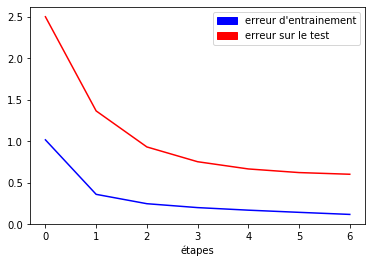

In [129]:
f(M, 8, 7, pas, eps,1,.2)

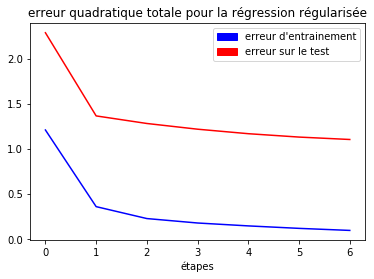

In [127]:
f(M, 8, 7, pas, eps,0,.2)

In [109]:
etape , perte_non_reg = comparaison(M, latent, iter, pas, eps, .2,0)
etape, perte_reg =  comparaison(M, latent, iter, pas, eps, .2,1)

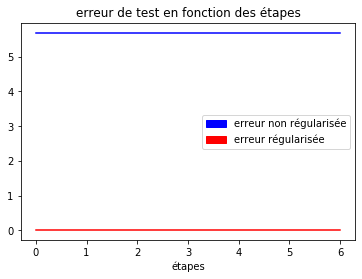

In [110]:
p1=plt.plot(etape, perte_reg, color='b')
p2=plt.plot(etape, perte_non_reg, color='r')
plt.title("erreur de test en fonction des étapes")
plt.xlabel("étapes")
blue_patch=mpatches.Patch(color='blue', label='erreur non régularisée')
red_patch = mpatches.Patch(color='red', label='erreur régularisée')
plt.legend(handles=[blue_patch,red_patch])
plt.show()

In [ ]:
"""def comparaison(M, l, iter, pas, eps,lamb,taille_test):
    # le paramètre courbe_seulement c'est si on veut afficher toutes les étapes ou juste les courbes pour comparer les résultats
    etape, perte_etape, temps, perte_temps = [], [], [], []
    perte_test_etape, perte_test_temps = [], []
    
    train, test = train_and_test(M,taille_test)
    
    M_old=M
    M=train
    
    MAT_U = np.array([[.1 for k in range(l)] for k in range(M.shape[0])])
    MAT_V = np.array([[.1 for k in range(l)] for k in range(M.shape[1])])
    L1 = [k for k in range(M.shape[0])]
    L2 = [k for k in range(M.shape[1])]
    rd.shuffle(L1)
    rd.shuffle(L2)

    #enlever les zeros
    paires=[]
    for i in L1:
        for j in L2:
            if M[i][j]!=0:
                paires.append((i,j))

    #if (courbes_seulement == False):
      #  print("Matrice à factoriser :")
      #  print(M)

    debut = time.time()

    for ww in range(iter):
        pas /= 1.1

        for paire in paires:
            n,m = paire
            a = float(M[n][m])
            U = MAT_U[n:n + 1]
            V = MAT_V[m:m + 1]
            e, ee = 0, 0

            # On minismise sur V à U constant
            while e<3:
                gradient = gradS_reg(a, U, V,lamb)
                #if (max(gradient) < eps) and (min(gradient) > -eps):
                    #break
                e += 1
                for i in range(l):
                    p1 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    V[0][i] -= pas * grad
                    p2 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        V[0][i] += pas * grad


            MAT_V[m] = V
                # On minimise sur U à V constant
            while ee<3:
                gradient = gradS_reg(a, U, V,lamb)
                #if (max(gradient) < eps) and (min(gradient) > -eps):
                    #break
                ee += 1
                for i in range(l):
                    p1 = perte_rapide_reg(M, MAT_U,MAT_V,n,m,lamb)
                    grad = gradient[i]
                    U[0][i] -= pas * grad
                    p2 = perte_rapide_reg(M,MAT_U,MAT_V,n,m,lamb)
                    if (p1 < p2):
                        U[0][i] += pas * grad

            MAT_U[n] = U

        #if (courbes_seulement == False):
           # print("etape", ww + 1, "sur", iter)
        etape.append(ww)
        perte=perte_quadr(M,MAT_U,MAT_V)
        perte_etape.append(perte)
        temps.append(time.time() - debut)
        perte_temps.append(perte)
        
        perte_t=perte_quadr(test,MAT_U,MAT_V)
        perte_test_etape.append(perte_t)
        perte_test_temps.append(perte_t)

    fin = time.time()
    #if (courbes_seulement == False):
       # print(MAT_U.dot(MAT_V.T))
        #print(M)
        
    
    return etape , perte_test_etape
"""

In [55]:
"""def comparaison_reg(M, l, iter, pas, eps, taille_test,lamb):

    train, test = train_and_test(M,taille_test)

    etape, perte_train_etape,perte_test_etape, temps, perte_train_temps, perte_test_temps = [], [], [], [], [],[]
    perte_train_etape_reg,perte_test_etape_reg, perte_train_temps_reg, perte_test_temps_reg = [], [], [], []

    MAT_U = np.array([[.1 for k in range(l)] for k in range(M.shape[0])])
    MAT_V = np.array([[.1 for k in range(l)] for k in range(M.shape[1])])
    MAT_U_reg = np.array([[.1 for k in range(l)] for k in range(M.shape[0])])
    MAT_V_reg = np.array([[.1 for k in range(l)] for k in range(M.shape[1])])
    
    L1 = [k for k in range(M.shape[0])]
    L2 = [k for k in range(M.shape[1])]
    rd.shuffle(L1)
    rd.shuffle(L2)

    # enlever les zeros sur le train, M doit rester intacte!!!
    paires = []
    for i in L1:
        for j in L2:
            if train[i][j] != 0:
                paires.append((i, j))


    debut = time.time()

    for ww in range(iter):
        pas /= 1.1

        for paire in paires:
            n, m = paire
            a = float(M[n][m])
            U = MAT_U[n:n + 1]
            V = MAT_V[m:m + 1]
            U_reg = MAT_U_reg[n:n + 1]
            V_reg = MAT_V_reg[m:m + 1]
            e, ee = 0, 0

            while e < 10:
                gradient=gradS(a,U,V)
                gradient_reg = gradS_reg(a, U, V)
                e += 1
                for i in range(l):
                    
                    p1_reg = perte_rapide_reg(train,MAT_U_reg,MAT_V_reg, n, m,lamb)
                    grad = gradient[i]
                    grad_reg = gradient_reg[i]
                    
                    V_reg[0][i] -= pas * grad_reg
                    
                    p2_reg = perte_rapide_reg(train,MAT_U_reg,MAT_V_reg, n, m,lamb)
                    
                    if (p1_reg < p2_reg):
                        V_reg[0][i] += pas * grad_reg

            MAT_V_reg[m]=V_reg
            
            
           
            while ee < 10:
                gradient=gradS(a,U,V)
                gradient_reg = gradS_reg(a, U, V)
                ee += 1
                for i in range(l):
                    
                    p1_reg = perte_rapide_reg(train,MAT_U_reg,MAT_V_reg, n, m,lamb)
                    grad = gradient[i]
                    grad_reg = gradient_reg[i]
                    
                    U_reg[0][i] -= pas * grad_reg
                    
                    p2_reg = perte_rapide_reg(train,MAT_U_reg,MAT_V_reg, n, m,lamb)
                    
                    if (p1_reg < p2_reg):
                        U_reg[0][i] += pas * grad_reg

            MAT_U_reg[m]=U_reg
            
            
            
            
        etape.append(ww)
        
        perte_train = perte_quadr(train, MAT_U,MAT_V)
        perte_train_reg=perte_quadr(train, MAT_U_reg,MAT_V_reg)
        
        perte_test=perte_quadr(test, MAT_U,MAT_V)
        perte_test_reg=perte_quadr(test, MAT_U_reg,MAT_V_reg)
        
        perte_train_etape.append(perte_train)
        perte_train_etape_reg.append(perte_train_reg)
        
        perte_test_etape.append(perte_test)
        perte_test_etape_reg.append(perte_test_reg)
        
        temps.append(time.time() - debut)
        
        perte_train_temps.append(perte_train)
        perte_train_temps_reg.append(perte_train_reg)
        
        perte_test_temps.append(perte_test)
        perte_test_temps_reg.append(perte_test_reg)


    
    p1=plt.plot(etape, perte_train_etape,color='b')
    p2=plt.plot(etape, perte_train_etape_reg,color='r')
    plt.title("erreur sur l'entrainement par étape")
    plt.xlabel("étapes")
    blue_patch=mpatches.Patch(color='blue', label='erreur non régularisée')
    red_patch = mpatches.Patch(color='red', label='erreur régularisée')
    plt.legend(handles=[blue_patch,red_patch])
    plt.show()

    
    p1=plt.plot(etape, perte_test_etape, color='b')
    p2=plt.plot(etape, perte_test_etape_reg, color='r')
    plt.title("erreur sur le test par étape")
    plt.xlabel("étapes")
    blue_patch=mpatches.Patch(color='blue', label='erreur non régularisée')
    red_patch = mpatches.Patch(color='red', label='erreur régularisée')
    plt.legend(handles=[blue_patch,red_patch])
    plt.show()
    

    p1=plt.plot(temps, perte_train_temps, color='b')
    p2=plt.plot(temps, perte_train_temps_reg, color='r')
    plt.title("erreur d'entrainement en fonction du temps")
    plt.xlabel("temps en secondes")
    blue_patch=mpatches.Patch(color='blue', label='erreur non régularisée')
    red_patch = mpatches.Patch(color='red', label='erreur régularisée')
    plt.legend(handles=[blue_patch,red_patch])
    plt.show()
    
    
    p1=plt.plot(temps, perte_test_temps, color='b')
    p2=plt.plot(temps, perte_test_temps_reg, color='r')
    plt.title("erreur de test en fonction du temps")
    plt.xlabel("temps en secondes")
    blue_patch=mpatches.Patch(color='blue', label='erreur non régularisée')
    red_patch = mpatches.Patch(color='red', label='erreur régularisée')
    plt.legend(handles=[blue_patch,red_patch])
    plt.show()
"""

'def comparaison_reg(M, l, iter, pas, eps, taille_test,lamb):\n\n    train, test = train_and_test(M,taille_test)\n\n    etape, perte_train_etape,perte_test_etape, temps, perte_train_temps, perte_test_temps = [], [], [], [], [],[]\n    perte_train_etape_reg,perte_test_etape_reg, perte_train_temps_reg, perte_test_temps_reg = [], [], [], []\n\n    MAT_U = np.array([[.1 for k in range(l)] for k in range(M.shape[0])])\n    MAT_V = np.array([[.1 for k in range(l)] for k in range(M.shape[1])])\n    MAT_U_reg = np.array([[.1 for k in range(l)] for k in range(M.shape[0])])\n    MAT_V_reg = np.array([[.1 for k in range(l)] for k in range(M.shape[1])])\n    \n    L1 = [k for k in range(M.shape[0])]\n    L2 = [k for k in range(M.shape[1])]\n    rd.shuffle(L1)\n    rd.shuffle(L2)\n\n    # enlever les zeros sur le train, M doit rester intacte!!!\n    paires = []\n    for i in L1:\n        for j in L2:\n            if train[i][j] != 0:\n                paires.append((i, j))\n\n\n    debut = time.time

In [107]:
dataset = pd.read_csv("datatset_restaurant.csv")
print(dataset.head())
M=to_matrice(dataset)
M=M[:50,:50]

  userID  placeID  rating  food_rating  service_rating
0  U1077   135085       2            2               2
1  U1077   135038       2            2               1
2  U1077   132825       2            2               2
3  U1077   135060       1            2               2
4  U1068   135104       1            1               2
Il y a  138  utilisateurs et  130 plats et  1161 notes, soit une matrice  6.47 % pleine.


In [106]:
pas = .1
eps = 0.01
iter=7
latent=8 #facteurs latents

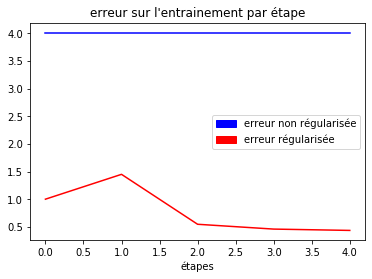

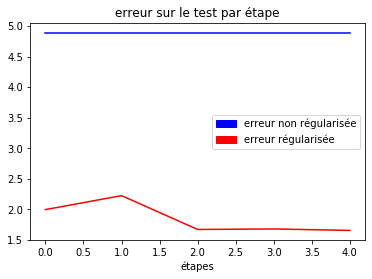

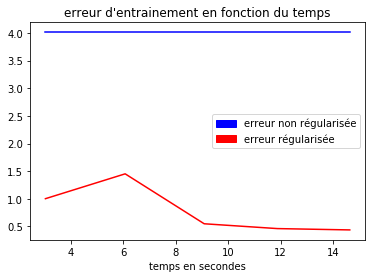

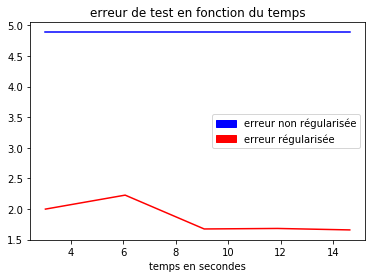

In [22]:
comparaison_reg(M,l,iter,pas,eps,.2,1)

In [ ]:
for l in range()

# Ce qu il faut faire : plot sur le meme graphes les evolution totalement reg et pas reg du tout (c est a dire pas reg dans les conditions de perte p1 < p2

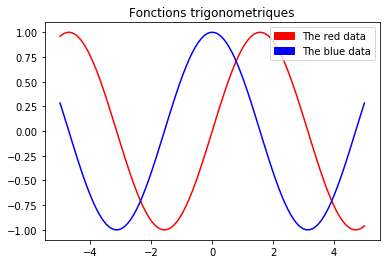

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

x=np.linspace(-5,5,100)

def f(x):
    p1=plt.plot(x,np.sin(x),color='r')
    return p1

def g(x):
    p2=plt.plot(x,np.cos(x),color='b')
    return p2

f(x)
g(x)
plt.title("Fonctions trigonometriques")  

red_patch = mpatches.Patch(color='red', label='The red data')
blue_patch=mpatches.Patch(color='blue', label='The blue data')
plt.legend(handles=[red_patch,blue_patch])

plt.show()